In [1]:
from sarpyx.processor.core.decode import decode_radar_file, extract_headers, save_pickle_file
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import logging

# Set up logging to see decoder progress
logging.basicConfig(level=logging.INFO)

# Sentinel-1 Level 0 Data Decoder Example

This notebook demonstrates how to use the SARPYX decoder to process Sentinel-1 Level 0 radar data files (.dat format). 

## Overview
The decoder extracts:
- **Echo bursts**: Raw radar data organized by burst
- **Metadata**: Header information for each packet
- **Ephemeris**: Satellite orbital and attitude data

## Setup
First, let's define the path to our sample data file.

In [3]:
# Define path to your Level 0 data file
# Replace this with the actual path to your .dat file
input_file = Path('/path/to/your/sample_data.dat')
input_file = "/Users/roberto.delprete/Library/CloudStorage/OneDrive-ESA/Desktop/Repos/SARPYX/notebooks/S1A_S3_RAW__0SDH_20240430T213606_20240430T213631_053668_0684A3_8760.SAFE/s1a-s3-raw-s-hh-20240430t213606-20240430t213631-053668-0684a3.dat"
input_file = Path(input_file)
# Check if file exists
if not input_file.exists():
    print(f'⚠️  File not found: {input_file}')
    print('Please update the path to point to your actual .dat file')
    sample_available = False
else:
    print(f'✅ Found data file: {input_file}')
    print(f'File size: {input_file.stat().st_size / (1024**2):.1f} MB')
    sample_available = True

✅ Found data file: /Users/roberto.delprete/Library/CloudStorage/OneDrive-ESA/Desktop/Repos/SARPYX/notebooks/S1A_S3_RAW__0SDH_20240430T213606_20240430T213631_053668_0684A3_8760.SAFE/s1a-s3-raw-s-hh-20240430t213606-20240430t213631-053668-0684a3.dat
File size: 711.3 MB


## Step 1: Extract Headers Only (Quick Preview)

First, let's extract just the headers to understand the data structure without processing the full radar data.

In [4]:
if sample_available:
    try:
        # Extract headers only (faster for initial exploration)
        print('Extracting headers...')
        headers_df = extract_headers(input_file, mode='s1isp')
        
        print(f'📊 Extracted {len(headers_df)} header records')
        print(f'Columns available: {list(headers_df.columns)[:10]}...')  # Show first 10 columns
        
        # Display basic info
        print('\n📈 Header DataFrame Info:')
        print(headers_df.info())
        
    except Exception as e:
        print(f'❌ Error extracting headers: {e}')
        sample_available = False

Extracting headers...


decoded: 48941 packets [00:01, 34916.96 packets/s]

2025-06-02 21:22:42,063 - INFO - Successfully extracted 48941 header records
2025-06-02 21:22:42,063 - INFO - Successfully extracted 48941 header records


📊 Extracted 48941 header records
Columns available: ['packet_version_number', 'packet_type', 'secondary_header_flag', 'pid', 'pcat', 'sequence_flags', 'packet_sequence_count', 'packet_data_length', 'coarse_time', 'fine_time']...

📈 Header DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48941 entries, 0 to 48940
Data columns (total 45 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   packet_version_number        48941 non-null  int64
 1   packet_type                  48941 non-null  int64
 2   secondary_header_flag        48941 non-null  bool 
 3   pid                          48941 non-null  int64
 4   pcat                         48941 non-null  int64
 5   sequence_flags               48941 non-null  int64
 6   packet_sequence_count        48941 non-null  int64
 7   packet_data_length           48941 non-null  int64
 8   coarse_time                  48941 non-null  int64
 9   fine_time      

In [5]:
if sample_available:
    # Explore signal types in the data
    signal_type_col = 'radar_configuration_support_ses_signal_type'
    
    if signal_type_col in headers_df.columns:
        signal_counts = headers_df[signal_type_col].value_counts()
        print('🎯 Signal Types Distribution:')
        signal_type_map = {0: 'Echo', 1: 'Noise', 8: 'TX Calibration'}
        
        for signal_type, count in signal_counts.items():
            type_name = signal_type_map.get(signal_type, f'Unknown ({signal_type})')
            print(f'  {type_name}: {count} records')
    
    # Show first few records
    print(f'\n📋 First 5 Header Records:')
    display_cols = [col for col in headers_df.columns[:5]]  # First 5 columns
    print(headers_df[display_cols].head())


📋 First 5 Header Records:
   packet_version_number  packet_type  secondary_header_flag  pid  pcat
0                      0            0                   True   65    12
1                      0            0                   True   65    12
2                      0            0                   True   65    12
3                      0            0                   True   65    12
4                      0            0                   True   65    12


## Step 2: Full Decoding with Radar Data

Now let's perform the complete decoding to extract burst data, metadata, and ephemeris.

In [6]:
if sample_available:
    try:
        print('🚀 Starting full decode process...')
        burst_data, burst_indexes = decode_radar_file(input_file)
        
        print(f'✅ Successfully decoded {len(burst_data)} bursts')
        print(f'📍 Burst indexes: {burst_indexes}')
        
        # Analyze each burst
        for i, burst in enumerate(burst_data):
            echo_shape = burst['echo'].shape
            metadata_len = len(burst['metadata'])
            ephemeris_len = len(burst['ephemeris'])
            
            print(f'\n📡 Burst {i}:')
            print(f'  Echo data shape: {echo_shape}')
            print(f'  Metadata records: {metadata_len}')
            print(f'  Ephemeris records: {ephemeris_len}')
            
            if len(echo_shape) > 1:
                print(f'  Samples per pulse: {echo_shape[1]}')
                print(f'  Number of pulses: {echo_shape[0]}')
        
    except Exception as e:
        print(f'❌ Decoding failed: {e}')
        burst_data = None

2025-06-02 21:23:17,204 - INFO - Starting decode process for: /Users/roberto.delprete/Library/CloudStorage/OneDrive-ESA/Desktop/Repos/SARPYX/notebooks/S1A_S3_RAW__0SDH_20240430T213606_20240430T213631_053668_0684A3_8760.SAFE/s1a-s3-raw-s-hh-20240430t213606-20240430t213631-053668-0684a3.dat


🚀 Starting full decode process...


decoded: 48941 packets [00:49, 998.68 packets/s] 
2025-06-02 21:24:06,701 - INFO - Decoded 48941 records from file
2025-06-02 21:24:06,702 - WARNING - Incomplete sub-commutated data cycle: 25
2025-06-02 21:24:06,703 - WARNING - Incomplete sub-commutated data cycle: 56
2025-06-02 21:24:06,707 - WARNING - Incomplete sub-commutated data cycle: 87
decoded: 48941 packets [00:49, 998.68 packets/s] 
2025-06-02 21:24:06,701 - INFO - Decoded 48941 records from file
2025-06-02 21:24:06,702 - WARNING - Incomplete sub-commutated data cycle: 25
2025-06-02 21:24:06,703 - WARNING - Incomplete sub-commutated data cycle: 56
2025-06-02 21:24:06,707 - WARNING - Incomplete sub-commutated data cycle: 87
2025-06-02 21:24:06,711 - WARNING - Incomplete sub-commutated data cycle: 118
2025-06-02 21:24:06,712 - WARNING - Incomplete sub-commutated data cycle: 149
2025-06-02 21:24:06,713 - WARNING - Incomplete sub-commutated data cycle: 180
2025-06-02 21:24:06,715 - WARNING - Incomplete sub-commutated data cycle: 

✅ Successfully decoded 2 bursts
📍 Burst indexes: [408, 19658, 48533]

📡 Burst 0:
  Echo data shape: (19250, 21838)
  Metadata records: 19250
  Ephemeris records: 762
  Samples per pulse: 21838
  Number of pulses: 19250

📡 Burst 1:
  Echo data shape: (28875, 21894)
  Metadata records: 28875
  Ephemeris records: 762
  Samples per pulse: 21894
  Number of pulses: 28875


## Step 3: Explore Radar Echo Data

Let's examine the actual radar echo data structure and characteristics.

In [7]:
if sample_available and burst_data:
    # Focus on first burst for detailed analysis
    first_burst = burst_data[0]
    echo_data = first_burst['echo']
    
    print('🔍 Echo Data Analysis:')
    print(f'Data type: {echo_data.dtype}')
    print(f'Shape: {echo_data.shape}')
    print(f'Memory usage: {echo_data.nbytes / (1024**2):.1f} MB')
    
    if echo_data.size > 0:
        # Check if data is complex
        if np.iscomplexobj(echo_data):
            print('✅ Data is complex (I/Q format)')
            print(f'Real part range: [{np.real(echo_data).min():.2f}, {np.real(echo_data).max():.2f}]')
            print(f'Imag part range: [{np.imag(echo_data).min():.2f}, {np.imag(echo_data).max():.2f}]')
        else:
            print('ℹ️  Data appears to be real-valued')
            print(f'Value range: [{echo_data.min():.2f}, {echo_data.max():.2f}]')
        
        # Basic statistics
        if len(echo_data.shape) == 2:
            print(f'\n📊 Per-pulse statistics (first 5 pulses):')
            for i in range(min(5, echo_data.shape[0])):
                pulse = echo_data[i]
                if np.iscomplexobj(pulse):
                    power = np.abs(pulse)**2
                    print(f'  Pulse {i}: Power mean={np.mean(power):.2e}, std={np.std(power):.2e}')
                else:
                    print(f'  Pulse {i}: Mean={np.mean(pulse):.2e}, std={np.std(pulse):.2e}')

🔍 Echo Data Analysis:
Data type: complex64
Shape: (19250, 21838)
Memory usage: 3207.3 MB
✅ Data is complex (I/Q format)
Real part range: [-82.47, 78.25]
Imag part range: [-78.25, 82.47]

📊 Per-pulse statistics (first 5 pulses):
  Pulse 0: Power mean=5.74e+00, std=6.30e+00
  Pulse 1: Power mean=5.72e+00, std=6.36e+00
  Pulse 2: Power mean=5.59e+00, std=5.65e+00
  Pulse 3: Power mean=5.50e+00, std=5.66e+00
  Pulse 4: Power mean=5.58e+00, std=6.12e+00
Real part range: [-82.47, 78.25]
Imag part range: [-78.25, 82.47]

📊 Per-pulse statistics (first 5 pulses):
  Pulse 0: Power mean=5.74e+00, std=6.30e+00
  Pulse 1: Power mean=5.72e+00, std=6.36e+00
  Pulse 2: Power mean=5.59e+00, std=5.65e+00
  Pulse 3: Power mean=5.50e+00, std=5.66e+00
  Pulse 4: Power mean=5.58e+00, std=6.12e+00


## Step 4: Visualize Radar Data

Create visualizations to understand the radar data characteristics.

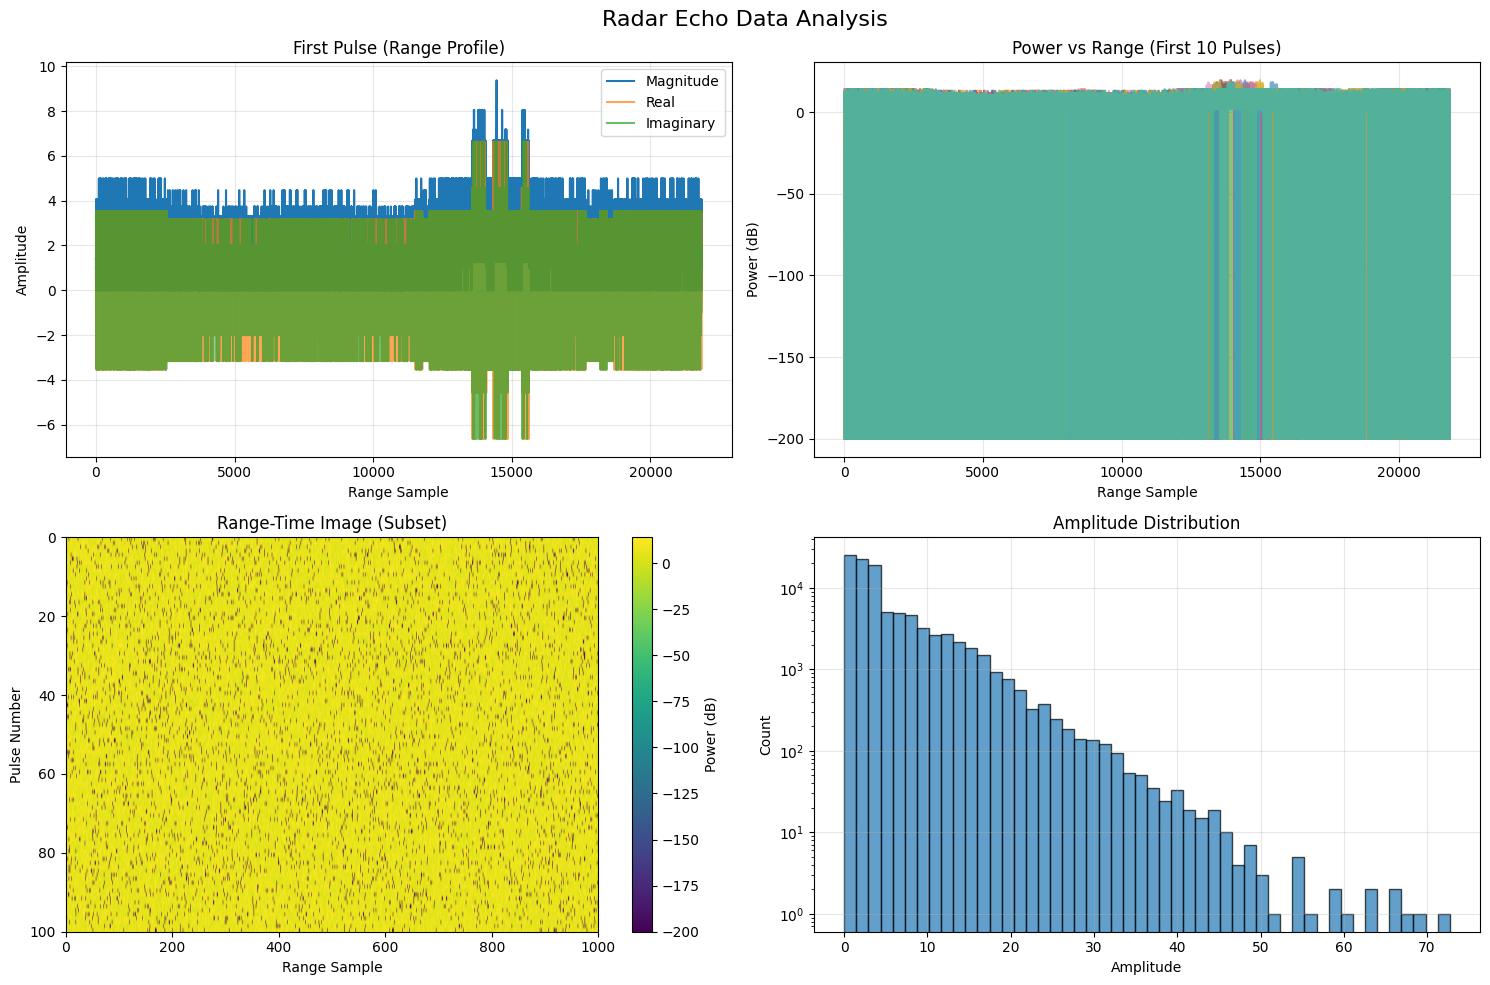

In [8]:
if sample_available and burst_data:
    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Radar Echo Data Analysis', fontsize=16)
    
    echo_data = burst_data[0]['echo']
    
    if echo_data.size > 0 and len(echo_data.shape) == 2:
        # Plot 1: First pulse (range profile)
        ax1 = axes[0, 0]
        first_pulse = echo_data[0]
        if np.iscomplexobj(first_pulse):
            ax1.plot(np.abs(first_pulse), label='Magnitude')
            ax1.plot(np.real(first_pulse), label='Real', alpha=0.7)
            ax1.plot(np.imag(first_pulse), label='Imaginary', alpha=0.7)
        else:
            ax1.plot(first_pulse, label='Amplitude')
        ax1.set_title('First Pulse (Range Profile)')
        ax1.set_xlabel('Range Sample')
        ax1.set_ylabel('Amplitude')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Plot 2: Power vs range (first few pulses)
        ax2 = axes[0, 1]
        n_pulses_to_show = min(10, echo_data.shape[0])
        for i in range(n_pulses_to_show):
            pulse = echo_data[i]
            if np.iscomplexobj(pulse):
                power_db = 20 * np.log10(np.abs(pulse) + 1e-10)
            else:
                power_db = 20 * np.log10(np.abs(pulse) + 1e-10)
            ax2.plot(power_db, alpha=0.6, label=f'Pulse {i}' if i < 3 else '')
        ax2.set_title(f'Power vs Range (First {n_pulses_to_show} Pulses)')
        ax2.set_xlabel('Range Sample')
        ax2.set_ylabel('Power (dB)')
        if n_pulses_to_show <= 3:
            ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # Plot 3: Range-Time Image (subset)
        ax3 = axes[1, 0]
        subset_data = echo_data[:min(100, echo_data.shape[0]), :min(1000, echo_data.shape[1])]
        if np.iscomplexobj(subset_data):
            power_data = 20 * np.log10(np.abs(subset_data) + 1e-10)
        else:
            power_data = 20 * np.log10(np.abs(subset_data) + 1e-10)
        
        im = ax3.imshow(power_data, aspect='auto', cmap='viridis', 
                       extent=[0, subset_data.shape[1], subset_data.shape[0], 0])
        ax3.set_title('Range-Time Image (Subset)')
        ax3.set_xlabel('Range Sample')
        ax3.set_ylabel('Pulse Number')
        plt.colorbar(im, ax=ax3, label='Power (dB)')
        
        # Plot 4: Histogram of signal amplitudes
        ax4 = axes[1, 1]
        if np.iscomplexobj(echo_data):
            amplitudes = np.abs(echo_data.flatten())
        else:
            amplitudes = np.abs(echo_data.flatten())
        
        # Sample data for histogram (to avoid memory issues)
        sample_size = min(100000, len(amplitudes))
        sample_indices = np.random.choice(len(amplitudes), sample_size, replace=False)
        sampled_amplitudes = amplitudes[sample_indices]
        
        ax4.hist(sampled_amplitudes, bins=50, alpha=0.7, edgecolor='black')
        ax4.set_title('Amplitude Distribution')
        ax4.set_xlabel('Amplitude')
        ax4.set_ylabel('Count')
        ax4.set_yscale('log')
        ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print('⚠️ No data available for visualization')

## Step 5: Explore Metadata

Examine the metadata associated with each burst.

In [9]:
if sample_available and burst_data:
    print('📋 Metadata Exploration:')
    
    for i, burst in enumerate(burst_data):
        metadata = burst['metadata']
        print(f'\n🔍 Burst {i} Metadata:')
        print(f'  Records: {len(metadata)}')
        print(f'  Columns: {len(metadata.columns)}')
        
        # Show key timing information if available
        time_cols = [col for col in metadata.columns if 'time' in col.lower()]
        if time_cols:
            print(f'  Time-related columns: {time_cols[:3]}...')
        
        # Show some sample values
        print('  Sample metadata (first record):')
        first_record = metadata.iloc[0]
        
        # Display a few key fields
        key_fields = []
        for col in metadata.columns:
            if any(keyword in col.lower() for keyword in ['coarse', 'fine', 'pri', 'swath']):
                key_fields.append(col)
        
        for field in key_fields[:5]:  # Show up to 5 key fields
            value = first_record[field]
            print(f'    {field}: {value}')
            
    # Compare metadata between bursts
    if len(burst_data) > 1:
        print(f'\n🔄 Comparing Bursts:')
        burst0_cols = set(burst_data[0]['metadata'].columns)
        burst1_cols = set(burst_data[1]['metadata'].columns)
        
        common_cols = burst0_cols & burst1_cols
        unique_to_0 = burst0_cols - burst1_cols
        unique_to_1 = burst1_cols - burst0_cols
        
        print(f'  Common columns: {len(common_cols)}')
        if unique_to_0:
            print(f'  Unique to burst 0: {len(unique_to_0)}')
        if unique_to_1:
            print(f'  Unique to burst 1: {len(unique_to_1)}')

📋 Metadata Exploration:

🔍 Burst 0 Metadata:
  Records: 19250
  Columns: 45
  Time-related columns: ['coarse_time', 'fine_time']...
  Sample metadata (first record):
    coarse_time: 1398548184
    fine_time: 40735
    pri_count: 4427
    pri: 19499
    swath_number: 2

🔍 Burst 1 Metadata:
  Records: 28875
  Columns: 45
  Time-related columns: ['coarse_time', 'fine_time']...
  Sample metadata (first record):
    coarse_time: 1398548194
    fine_time: 40750
    pri_count: 23677
    pri: 19499
    swath_number: 2

🔄 Comparing Bursts:
  Common columns: 45


## Step 6: Explore Ephemeris Data

Examine the satellite ephemeris and attitude data.

In [10]:
if sample_available and burst_data:
    ephemeris = burst_data[0]['ephemeris']  # Same for all bursts
    
    if not ephemeris.empty:
        print('🛰️ Ephemeris Data:')
        print(f'Records: {len(ephemeris)}')
        print(f'Columns: {len(ephemeris.columns)}')
        print(f'Columns: {list(ephemeris.columns)}')
        
        # Look for position and velocity data
        pos_cols = [col for col in ephemeris.columns if 'pos' in col.lower() or 'position' in col.lower()]
        vel_cols = [col for col in ephemeris.columns if 'vel' in col.lower() or 'velocity' in col.lower()]
        att_cols = [col for col in ephemeris.columns if 'att' in col.lower() or 'attitude' in col.lower()]
        
        if pos_cols:
            print(f'Position columns: {pos_cols}')
        if vel_cols:
            print(f'Velocity columns: {vel_cols}')
        if att_cols:
            print(f'Attitude columns: {att_cols}')
        
        # Show sample ephemeris data
        print('\n📊 Sample Ephemeris Records:')
        print(ephemeris.head())
        
        # Plot ephemeris if we have position data
        if pos_cols and len(pos_cols) >= 3:
            fig, axes = plt.subplots(2, 2, figsize=(12, 8))
            fig.suptitle('Satellite Ephemeris Data', fontsize=14)
            
            # Position components
            ax1 = axes[0, 0]
            for i, col in enumerate(pos_cols[:3]):
                if col in ephemeris.columns:
                    ax1.plot(ephemeris[col], label=f'{col}', marker='o', markersize=2)
            ax1.set_title('Satellite Position')
            ax1.set_xlabel('Record Number')
            ax1.set_ylabel('Position (m)')
            ax1.legend()
            ax1.grid(True, alpha=0.3)
            
            # Velocity components (if available)
            ax2 = axes[0, 1]
            for i, col in enumerate(vel_cols[:3]):
                if col in ephemeris.columns:
                    ax2.plot(ephemeris[col], label=f'{col}', marker='o', markersize=2)
            ax2.set_title('Satellite Velocity')
            ax2.set_xlabel('Record Number')
            ax2.set_ylabel('Velocity (m/s)')
            ax2.legend()
            ax2.grid(True, alpha=0.3)
            
            # 3D orbit plot (if we have X, Y, Z positions)
            ax3 = axes[1, 0]
            if len(pos_cols) >= 3:
                x_data = ephemeris[pos_cols[0]]
                y_data = ephemeris[pos_cols[1]]
                z_data = ephemeris[pos_cols[2]]
                
                # Project to 2D for visualization
                ax3.plot(x_data, y_data, 'b-', linewidth=2, alpha=0.7)
                ax3.scatter(x_data.iloc[0], y_data.iloc[0], color='green', s=50, label='Start')
                ax3.scatter(x_data.iloc[-1], y_data.iloc[-1], color='red', s=50, label='End')
                ax3.set_title('Orbital Track (X-Y Projection)')
                ax3.set_xlabel('X Position (m)')
                ax3.set_ylabel('Y Position (m)')
                ax3.legend()
                ax3.grid(True, alpha=0.3)
                ax3.axis('equal')
            
            # Time series plot (if we have time information)
            ax4 = axes[1, 1]
            time_cols_eph = [col for col in ephemeris.columns if 'time' in col.lower()]
            if time_cols_eph:
                ax4.plot(ephemeris[time_cols_eph[0]], marker='o', markersize=2)
                ax4.set_title(f'Time Series: {time_cols_eph[0]}')
                ax4.set_xlabel('Record Number')
                ax4.set_ylabel('Time')
            else:
                ax4.text(0.5, 0.5, 'No time data\navailable', 
                        ha='center', va='center', transform=ax4.transAxes)
                ax4.set_title('Time Information')
            ax4.grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.show()
    else:
        print('⚠️ No ephemeris data available')

🛰️ Ephemeris Data:
Records: 762
Columns: 59
Columns: ['x', 'y', 'z', 'vx', 'vy', 'vz', 'time_stamp', 'q0', 'q1', 'q2', 'q3', 'omega_x', 'omega_y', 'omega_z', 'pointing_status', 'temperature_update_status', 'tile1_efeh_temperature', 'tile1_efev_temperature', 'tile1_ta_temperature', 'tile2_efeh_temperature', 'tile2_efev_temperature', 'tile2_ta_temperature', 'tile3_efeh_temperature', 'tile3_efev_temperature', 'tile3_ta_temperature', 'tile4_efeh_temperature', 'tile4_efev_temperature', 'tile4_ta_temperature', 'tile5_efeh_temperature', 'tile5_efev_temperature', 'tile5_ta_temperature', 'tile6_efeh_temperature', 'tile6_efev_temperature', 'tile6_ta_temperature', 'tile7_efeh_temperature', 'tile7_efev_temperature', 'tile7_ta_temperature', 'tile8_efeh_temperature', 'tile8_efev_temperature', 'tile8_ta_temperature', 'tile9_efeh_temperature', 'tile9_efev_temperature', 'tile9_ta_temperature', 'tile10_efeh_temperature', 'tile10_efev_temperature', 'tile10_ta_temperature', 'tile11_efeh_temperature', 'til

## Step 7: Save Processed Data

Finally, let's save the processed data for further analysis.

In [11]:
if sample_available and burst_data:
    # Create output directory
    output_dir = Path('./processed_data')
    output_dir.mkdir(exist_ok=True)
    
    file_stem = input_file.stem
    
    print(f'💾 Saving processed data to: {output_dir}')
    
    # Save ephemeris (once for all bursts)
    if not burst_data[0]['ephemeris'].empty:
        ephemeris_path = output_dir / f'{file_stem}_ephemeris.pkl'
        burst_data[0]['ephemeris'].to_pickle(ephemeris_path)
        print(f'✅ Saved ephemeris: {ephemeris_path}')
    
    # Save each burst
    for i, burst in enumerate(burst_data):
        # Save metadata
        metadata_path = output_dir / f'{file_stem}_burst_{i}_metadata.pkl'
        burst['metadata'].to_pickle(metadata_path)
        
        # Save radar data
        radar_path = output_dir / f'{file_stem}_burst_{i}_echo.pkl'
        save_pickle_file(radar_path, burst['echo'])
        
        print(f'✅ Saved burst {i}: metadata and echo data')
    
    print(f'\n🎉 Processing complete! All data saved to {output_dir}')
    
    # Summary
    total_size = sum(f.stat().st_size for f in output_dir.glob('*.pkl'))
    print(f'📊 Total output size: {total_size / (1024**2):.1f} MB')
    print(f'📁 Files created: {len(list(output_dir.glob("*.pkl")))}')
else:
    print('⚠️ No data to save - please check your input file path')

💾 Saving processed data to: processed_data
✅ Saved ephemeris: processed_data/s1a-s3-raw-s-hh-20240430t213606-20240430t213631-053668-0684a3_ephemeris.pkl


2025-06-02 21:26:10,483 - INFO - Successfully saved pickle file: processed_data/s1a-s3-raw-s-hh-20240430t213606-20240430t213631-053668-0684a3_burst_0_echo.pkl


✅ Saved burst 0: metadata and echo data


2025-06-02 21:26:14,885 - INFO - Successfully saved pickle file: processed_data/s1a-s3-raw-s-hh-20240430t213606-20240430t213631-053668-0684a3_burst_1_echo.pkl


✅ Saved burst 1: metadata and echo data

🎉 Processing complete! All data saved to processed_data
📊 Total output size: 8046.1 MB
📁 Files created: 5


## Summary

This notebook demonstrated:

1. **Header Extraction**: Quick preview of file structure
2. **Full Decoding**: Extract bursts, metadata, and ephemeris
3. **Data Analysis**: Explore radar echo characteristics
4. **Visualization**: Plot radar data and ephemeris information  
5. **Data Export**: Save processed data for further analysis

### Next Steps

- Use the saved pickle files for focused analysis
- Implement range compression algorithms
- Perform azimuth focusing for SAR processing
- Analyze Doppler characteristics
- Calibrate the radar data using calibration pulses

### Key Functions Used

- `decode_radar_file()`: Complete file decoding
- `extract_headers()`: Header-only extraction
- `save_pickle_file()`: Robust data saving

For more advanced processing, explore the other modules in the SARPYX toolkit!